In [1]:
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
require("lightgbm")
require("ggplot2")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,613884,32.8,1330087,71.1,1128919,60.3
Vcells,1149420,8.8,8388608,64.0,1801055,13.8


Loading required package: data.table

Loading required package: lightgbm

Loading required package: ggplot2



In [2]:
#setwd("C:/_MCD/Labo1/code")  #Establezco el Working Directory
setwd( "~/buckets/b1" )

kexperimento  <- "comp2-exp14"
ksubexperimento <- "B"
ksemilla_azar  <- 100019

In [3]:
dataset_finalTrain  <- fread( paste0( "./exp/", kexperimento, "/dataset_train_final.csv.gz" ) )

dataset_future  <- fread( paste0( "./exp/", kexperimento, "/dataset_future.csv.gz" ) )

In [4]:
kmax_bin           <-    31

knum_iterations    <- 2005








klearning_rate     <-  0.0109599323133051





 



knum_leaves        <-  1993









kmin_data_in_leaf  <-  2315









kfeature_fraction  <-   0.52590352765338









In [5]:
#dataset  <- fread(kdataset, stringsAsFactors= TRUE)

#paso la clase a binaria que tome valores {0,1}  enteros
#set trabaja con la clase  POS = { BAJA+1, BAJA+2 } 
#esta estrategia es MUY importante
dataset_finalTrain[ , clase01 := ifelse( clase_ternaria %in%  c("BAJA+2","BAJA+1"), 1L, 0L) ]

#los campos que se van a utilizar
campos_buenos  <- setdiff( colnames(dataset_finalTrain), c("clase_ternaria","clase01","foto_mes") )

#creo las carpetas donde van los resultados
#creo la carpeta donde va el experimento
# HT  representa  Hiperparameter Tuning
dir.create( "./exp/",  showWarnings = FALSE ) 
dir.create( paste0("./exp/", kexperimento, "/" ), showWarnings = FALSE )
setwd( paste0("./exp/", kexperimento, "/" ) )   #Establezco el Working Directory DEL EXPERIMENTO


#dejo los datos en el formato que necesita LightGBM
dtrain  <- lgb.Dataset( data= data.matrix(  dataset_finalTrain[, campos_buenos, with=FALSE]),
                        label= dataset_finalTrain[ , clase01] )

#aplico el modelo a los datos sin clase
dapply  <- dataset_future

In [6]:
dapply[,foto_mes:=NULL]

In [7]:
#genero el modelo
#estos hiperparametros  salieron de una laaarga Optmizacion Bayesiana
modelo  <- lgb.train( data= dtrain,
                      param= list( objective=          "binary",
                                   max_bin=            kmax_bin,
                                   learning_rate=      klearning_rate,
                                   num_iterations=     knum_iterations,
                                   num_leaves=         knum_leaves,
                                   min_data_in_leaf=   kmin_data_in_leaf,
                                   feature_fraction=   kfeature_fraction,
                                   seed=               ksemilla_azar
                                  )
                    )

[LightGBM] [Info] Number of positive: 1979, number of negative: 160921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 162900, number of used features: 165
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012149 -> initscore=-4.398322
[LightGBM] [Info] Start training from score -4.398322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [8]:
#--------------------------------------
#ahora imprimo la importancia de variables
tb_importancia  <-  as.data.table( lgb.importance(modelo) ) 
archivo_importancia  <- paste0("pred_impo_",ksubexperimento,"_",kexperimento,".csv")

fwrite( tb_importancia, 
        file= archivo_importancia, 
        sep= "\t" )

In [9]:
#aplico el modelo a los datos nuevos
prediccion  <- predict( modelo, 
                        data.matrix( dapply[, campos_buenos, with=FALSE ])                                 )

#genero la tabla de entrega
tb_entrega  <-  dapply[ , list( numero_de_cliente ) ]
tb_entrega[  , prob := prediccion ]

#grabo las probabilidad del modelo
#fwrite( tb_entrega,
#        file= "prediccion.txt",
#        sep= "\t" )

#ordeno por probabilidad descendente
setorder( tb_entrega, -prob )

In [10]:
#prob_corte <- 0.0372744903634901
#tb_entrega[  , Predicted := 0L ]
#tb_entrega[ prob >= prob_corte, Predicted := 1L ]

#  fwrite( tb_entrega[ , list(numero_de_cliente, Predicted)], 
#          file= paste0(  kexperimento, "_prob_corte.csv" ),
#          sep= "," )

In [11]:
#genero archivos con los  "envios" mejores
#deben subirse "inteligentemente" a Kaggle para no malgastar submits
cortes <- seq( 8500, 11000, by=500 )

for( envios  in  cortes )
{
  tb_entrega[  , Predicted := 0L ]
  tb_entrega[ 1:envios, Predicted := 1L ]

  fwrite( tb_entrega[ , list(numero_de_cliente, Predicted)], 
          file= paste0(  "pred_",ksubexperimento,"_",kexperimento, "_", envios, ".csv" ),
          sep= "," )
}

In [12]:
prediccion  <- predict( modelo, 
                        data.matrix( dataset_finalTrain[, campos_buenos, with=FALSE ])                                 )

dataset_finalTrain[  , prob_baja2 := prediccion ]

#Dibujo las curvas de ganancia
setorder( dataset_finalTrain,  -prob_baja2 )

#agrego una columna que es la de las ganancias
dataset_finalTrain[ , gan :=  ifelse( clase_ternaria=="BAJA+2", 78000, -2000 ) ]
dataset_finalTrain[ , ganancia_acumulada := cumsum( gan ) ]
dataset_finalTrain[ , pos := sequence(.N) ]


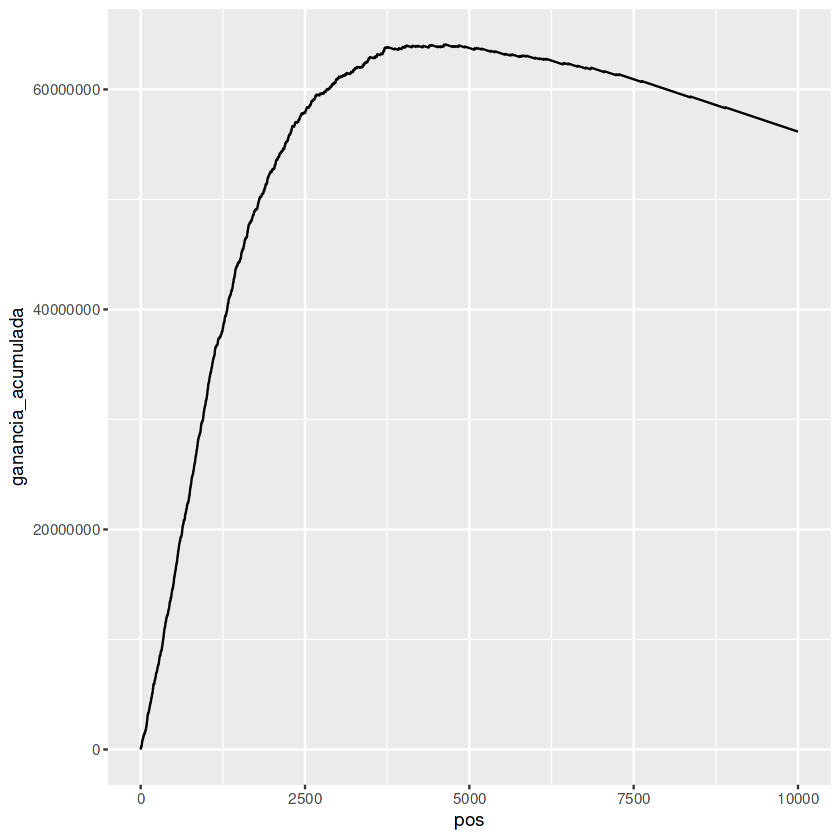

In [13]:
options(scipen=999)

##segundo grafico
ggplot(data = dataset_finalTrain[ pos <= 10000], aes(x = pos, y = ganancia_acumulada) ) +
    geom_line()